### U-Net
<br>
<img width="600" height="600" role="presentation" src="https://miro.medium.com/max/902/1*O2NbipwBOdTMtj7ThBNTPQ.png">

논문 링크: <a href="https://arxiv.org/pdf/1505.04597.pdf">U-net</a><br>

Semantic Segmentation의 가장 기본적으로 많이 사용하는 Model인 U-Net을 알아보자.  
U-Net은 말 그대로 Model의 형태가 U자로 생겨서 U-Net이다.  
대표적인 AutoEncoder로 구현한 Model중에 하나이다.  

U-Net의 대표적인 특징은 3가지 이다.  
1. Contraction Path(Encoder)와 Expansion Path(Decoder)로 이루워진 Fully Convolution + Deconvolution의 구조를 가진 AutoEncoder Model이다.
2. Expanding Path에서 Upsampling시 좀더 정확한 Localization을 하기 위하여 COntraction Path의 Feature map을 Copy and Crop하는 구조이다.
3. Dataset이 적으므로 Trainning의 정확도를 올리기 위하여 Data Augmentaion을 통하여 Dataset을 가공하여 사용하였다.

### Overlap Tile Strategy
<img width="600" height="600" role="presentation" src="https://miro.medium.com/max/557/1*GNB3UkI-hErQwvL-jDLU7A.png">

Overlap Tile Strategy는 unpaddes convolution을 실행함으로서 Output Size는 Input Size보다 작아지게 된다.  
따라서 DownSizing 과 Upsampling시 Ovelap tile을 사용하게 된다.  
Over Lap Tile은 다음과 같은 순서로 진행된다.

Image를 Patch 단위로 가져오기 위해서 가장자리 부분을 **Mirroring하여 Padding을 추가한뒤 Patch단위로 자른다..**
**Mirroring**을 자세히 보면 아래 그림과 같다.
<img width="400" height="400" role="presentation" src="https://modulabs-biomedical.github.io/assets/images/posts/2018-04-02-U_Net/u-net_fig_2_ex.png">

<br>
Boundary는 부자연 하므로 Patch에서 일정 부분만 Segmentation으로서 사용한다. 또한 Overlap이라고 불리는 이유는 아래와 같이 Tile이 겹쳐서 뽑아내기 때문이다. 
<img width="600" height="600" role="presentation" src="https://modulabs-biomedical.github.io/assets/images/posts/2018-04-02-U_Net/u-net_fig_2_overlap.png">

### Data Augmentaion
현재 논문에서 강조하는 Model의 성능향상을 종합해보면 크게 2가지라 할 수 있다.

1. U-Net구조의 Model사용(Copy and Crop)
2. Data Augmentation

이 중 Data Augmentation의 특징을 알아보자
현재 사용하고 있는 Biomedical Data의 경우 전문가에 의해 Annotation되어야 하므로 DataSet의 크기가 작을 수 밖에 없다.  
따라서 이러한 부족한 수의 DataSet을 늘리는 방법을 **Data Augmentaion**이라 한다.  
현재 사용하고 있는 Data의 Augmentaion을 Elastic Deformation을 사용하였다.  
**Elastic Deformation** 
<img width="600" height="600" role="presentation" src="https://miro.medium.com/max/488/1*tKP4KxFTzQZiIBdANn1PVA.png">

위와 같이 Elastic Deformation을 사용한 이유도 **Biomedical Image의 특성**때문이다.  
**Boundary를 직사각형으로 균등하게 자르는 경우 Boundary안에 정확한 Cell이 존재하지 않을 확률이 높다.**  
따라서 **Elastic Deformation을 통하여 Boundary안에 Cell이 최대한 많이 분포하기 위해 처리해주는 과정이다.**  
<a href="https://en.wikipedia.org/wiki/Transformation_matrix">Transformation Matrix자세한 내용</a><br>


현재 전문적인 지식이 필요한 부분으로 인하여 미리 정제되어 있는 DataSet을 가져와 사용하였다.  
아래 링크는 Data의 Input 과 Label을 DataAugmentaion을 하여 사용하는 과정까지 자세히 나와있는 링크이다.  
아래 링크에서 Data Augmentaion된 Data를 활용하여 Model을 학습하였다.  
<a href="https://github.com/zhixuhao/unet">데이터 출처: zhixuhao Git</a>

#### 필요한 Library Import

In [1]:
!pwd

/Users/alexkim/Documents/GitHub/Dacon_Can_de/WorkSpace/KIM/Pytorch-master/U-Net


In [2]:
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
import cv2
from torchvision import transforms, datasets
from torchvision.transforms import ToPILImage
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torch.utils.data as data
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms

#### DataAugmentation 개수와 GPU 확인

In [5]:
files = [f for f in listdir('./Data/aug') if isfile(join('./Data/aug', f))]
test_image_name = [x for x in files if x.find("image") != -1]
mask_image_name = [x for x in files if x.find("mask") != -1]

print('File 개수 확인')
print(len(test_image_name))
print(len(mask_image_name))

print('Deviece 확인')
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
print(device)


loader = transforms.Compose([
    transforms.ToTensor()])  # 토치 텐서로 변환


def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

train = []
label = []

for i in range(len(test_image_name)):
    image = image_loader('./Data/aug/' + test_image_name[i])
    train.append(image)

for i in range(len(mask_image_name)):
    image = image_loader('./Data/aug/' + mask_image_name[i])
    label.append(image)

File 개수 확인
60
60
Deviece 확인
mps:0


#### Image를 Tensor로 변환후 정보 확인

In [6]:
print('Train Image -> Tensor 확인')
print(len(train))
print(train[0].size())
print(train[0])
print('Label Image -> Tensor 확인')
print(len(label))
print(label[0].size())
print(label[0])

Train Image -> Tensor 확인
60
torch.Size([1, 1, 256, 256])
tensor([[[[0.6000, 0.6078, 0.7765,  ..., 0.4000, 0.6078, 0.6000],
          [0.6157, 0.6471, 0.6549,  ..., 0.6706, 0.7529, 0.7059],
          [0.5647, 0.5608, 0.6314,  ..., 0.7255, 0.6196, 0.4392],
          ...,
          [0.7059, 0.5294, 0.2745,  ..., 0.6353, 0.6235, 0.6549],
          [0.5961, 0.4275, 0.3333,  ..., 0.6902, 0.7137, 0.6902],
          [0.3255, 0.2000, 0.2784,  ..., 0.4549, 0.4549, 0.5059]]]],
       device='mps:0')
Label Image -> Tensor 확인
60
torch.Size([1, 1, 256, 256])
tensor([[[[1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          [1., 1., 1.,  ..., 0., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]], device='mps:0')


/opt/homebrew/Caskroom/miniforge/base/envs/alex/lib/python3.9/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


#### Tensor로 변환한 Image출력

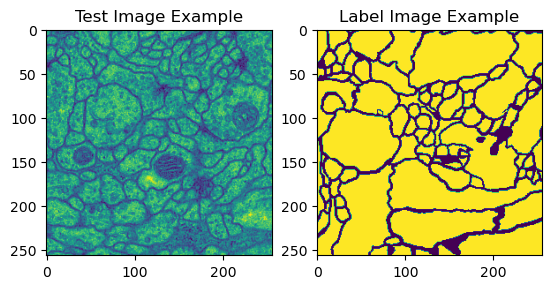

In [7]:
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # 텐서의 값에 변화가 적용되지 않도록 텐서를 복제합니다
    image = image.squeeze(0)      # 페이크 배치 차원을 제거 합니다
    image = unloader(image)
    plt.imshow(image)
    
test_image_example = plt.subplot(1,2,1)
test_image_example.set_title('Test Image Example')
imshow(train[0])

label_image_example = plt.subplot(1,2,2)
label_image_example.set_title('Label Image Example')
imshow(label[0])

In [32]:
train[0].shape

torch.Size([1, 1, 256, 256])

#### Batch처리를 위하여 Data를 BatchSize = 2 로서 묶는 과정

In [8]:
train_batch = []
label_batch = []
batch_size = 2
for i in range(0,len(train),batch_size):
    train_batch.append(torch.cat([train[i],train[i+1]]))

for i in range(0,len(label),2):
    try:
        label_batch.append(torch.cat([label[i],label[i+1]]))
    except:
        pass

In [35]:
train_batch[0].shape

torch.Size([2, 1, 256, 256])

#### 최종 Train에 사용할 Data 정보 확인

In [9]:
print('Batch 개수 확인')
print(len(train_batch))
print(len(label_batch))
print('Batch Tensor 정보 확인')
print(label_batch[0].size())

Batch 개수 확인
30
30
Batch Tensor 정보 확인
torch.Size([2, 1, 256, 256])


In [37]:
train_batch[0].shape

torch.Size([2, 1, 256, 256])

### Model

Model을 단순하게 살펴보면 다음과 같다.  
<img src="https://modulabs-biomedical.github.io/assets/images/posts/2018-04-02-U_Net/u-net_fig_1.png"/>

Model의 Encoder부분인 Contracting Path와 Decoder부분인 Expanding Path부분으로 크게 두가지고 나눌 수 있다. 각각의 특징을 살펴보면 다음과 같다.  
**Contracting Path**  
1. Fully Connected Convolution Networ구조
2. 3 x 3 Convolution을 반복 수행
3. Activation Function: ReLU
4. 2 x 2 Max Pooling: Stride 2를 사용하여 1/2로 Scaling
5. Downsampling 시에는 2배의 Feature Channel사용

Contracting Path로 인하여 64 Channel의 Input Image는 1024의 Channel로서 향상 될 수 있다.  
이러한 늘어난 Encoder의 Output만을 사용하는 것은 전체적인 Image의 Feature를 가져올 수 없다는 단점이 생기게 된다.  
따라서 Upsampling시 **Copy and Crop**을 사용하여 같은 Channel인 Contracting Path의 Feature Map을 붙여서 Input으로 활용하는 것을 알 수 있다.  
>One important modification in our architecture is that in the upsampling
part we have also a large number of feature channels, which allow the network
to propagate context information to higher resolution layers. As a consequence,
the expansive path is more or less symmetric to the contracting path, and yields
a u-shaped architecture

**Expanding Path**  
1. 2 x 2 convolution(up-convolution)
2. Feature channel을 반으로 줄여서 사용
3. **Contracting Path에서 Max-Pooling 되기 전의 Feature map을 Crop하여 Up-Convolution할 때 Concatenation을 수행**
4. 3 x 3 Convolution 반복
5. ReLu사용

여기서 **가장 중요한 것은 AutoEncoder의 구조이지만 Input Image의 전체적인 특성을 가져오기 위하여 Contracting Path의 중간중가 결과물인 Feature Map을 Copy and Crop한다는 것** 이다.

In [10]:
# 자주 쓰는 연산들과 항상 세트로 쓰는 연산들은 편의를 위해 함수로 정의해 놓습니다.

def conv_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def conv_trans_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim,out_dim, kernel_size=3, stride=2, padding=1,output_padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool

def conv_block_2(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        conv_block(in_dim,out_dim,act_fn),
        nn.Conv2d(out_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model   

#### Copy and Crop
개인적으로 **U-net**에서 가장 중요한 부분이다.  
U-net에서 가장 중요한 부분인 **Copy and Crop**을 다음과 같이 구현하였다.  
<code>concat_1 = torch.cat([trans_1,down_4],dim=1)</code><br>
<code>up_1 = self.up_1(concat_1)</code><br>
위의 Code를 보게 되면 Contraction Path에서 뽑아낸 Feature Map을 합쳐서 Input으로 들어가는 것을 확인할 수 있다.

In [11]:
class UnetGenerator(nn.Module):
    def __init__(self,in_dim,out_dim,num_filter):
        super(UnetGenerator,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)

        print("\n------Initiating U-Net------\n")

        self.down_1 = conv_block_2(self.in_dim,self.num_filter,act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter*1,self.num_filter*2,act_fn)
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter*2,self.num_filter*4,act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter*4,self.num_filter*8,act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter*8,self.num_filter*16,act_fn)

        self.trans_1 = conv_trans_block(self.num_filter*16,self.num_filter*8,act_fn)
        self.up_1 = conv_block_2(self.num_filter*16,self.num_filter*8,act_fn)
        self.trans_2 = conv_trans_block(self.num_filter*8,self.num_filter*4,act_fn)
        self.up_2 = conv_block_2(self.num_filter*8,self.num_filter*4,act_fn)
        self.trans_3 = conv_trans_block(self.num_filter*4,self.num_filter*2,act_fn)
        self.up_3 = conv_block_2(self.num_filter*4,self.num_filter*2,act_fn)
        self.trans_4 = conv_trans_block(self.num_filter*2,self.num_filter*1,act_fn)
        self.up_4 = conv_block_2(self.num_filter*2,self.num_filter*1,act_fn)
        
        self.out = nn.Sequential(
            nn.Conv2d(self.num_filter,self.out_dim,3,1,1),
            nn.Tanh(),  #필수는 아님
        )
        
            
    def forward(self,input):
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)
        concat_1 = torch.cat([trans_1,down_4],dim=1)
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = torch.cat([trans_2,down_3],dim=1)
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = torch.cat([trans_3,down_2],dim=1)
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = torch.cat([trans_4,down_1],dim=1)
        up_4 = self.up_4(concat_4)
        out = self.out(up_4)
        return out

#### Loss and Optimizer
**Optimizer**  
Optimizer의 경우 SGD를 사용하고 **Batch size를 크게해서 학습시키는 것 보다 Input Tile의 size를 크게 주는 방법을 선택**하였다.  
이에 관련된 이유는 Image를 일정 크기(Patch)로서 자르게 되는데 너무 작게 자르게 되는 경우 Image자체의 Context의 의미가 없어지므로 이러한 선택을 하였다.  
이러한 **Batch Size가 작기 때문에, 이를 보안하고자 momentum의 값을 0.99를 주어서 과거의 겂들을 더 많이 반영하게 하여 학습이 진행하도록 하였다.**  

**Loss Function**  
Biomedical Image의 특성상 Cell이 서로 인접하여서 구분하기 힘든 특징이 있다.  
각각의 Cell과 배경은 잘 구분되는 특징은 있지만, 각각의 Cell이 구분되지 않는 특징이 존재하게 된다.  

이러한 특성 때문에 서로 붙어있는 물체를 쉽게 합치고 떨어뜨리기 위하여, Weight map을 추가하여 Network의 Output을 결정하게 된다.
- $d_1(x)$: 가장 근접한 Cell의 경계와의 거리
- $d_2(x)$: 두번째로 근접한 Cell의 경계와의 거리
$$w(x) = w_c(x) + w_0 * exp(-\frac{(d_1(x) + d_2(x))^2}{2\alpha^2})$$

이러한 Weight Map을 통하여 Loss Function을 정의하게 되면 Cross Entropy를 사용할 시 다음과 같이 나타낼 수 있다.
$$E = \sum_{x \in \Omega}w(x)log(p_{l(x)}(x))$$

위와 같은 결과로서 얻는 Image의 변환은 아래와 같다.
<img width="600" height="250" role="presentation" src="http://openresearch.ai/uploads/default/original/1X/5f404882292f729534593e970b891346fe270f10.png">

**위의 사진에서도 알 수 있듯이 Cell이 인접해 있으면, 각 셀과 배경을 구분하도록 둘 사이에 배경으로 인식할 틈을 만들겠다는 의미이다.**

#### 간단한 $w_c(x)$ 확인

img_numpy Check
[[255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 [255 255 255 ...   0   0   0]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
After Kernel Check
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


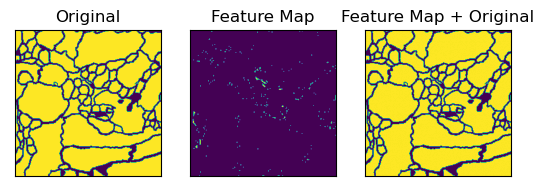

In [12]:
def imshow2(tensor, title=None):
    image = tensor.cpu().clone()  # 텐서의 값에 변화가 적용되지 않도록 텐서를 복제합니다
    image = image.squeeze(0)      # 페이크 배치 차원을 제거 합니다
    image = unloader(image)
    return image

img = imshow2(label[0])
img_numpy = np.array(img)
print('img_numpy Check')
print(img_numpy)


kernel = np.ones((3,3),np.uint8)
result = cv2.morphologyEx(img_numpy/255, cv2.MORPH_TOPHAT, kernel)

print('After Kernel Check')
print(result)

plt.subplot(131),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(result),plt.title('Feature Map')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(img+result),plt.title('Feature Map + Original')
plt.xticks([]),plt.yticks([])
plt.show()

#### Hyper Parameter 및 Model, Loss 선언

원래 Loss는 아래와 같다.
**Weight Map**  
- $d_1(x)$: 가장 근접한 Cell의 경계와의 거리
- $d_2(x)$: 두번째로 근접한 Cell의 경계와의 거리
$$w(x) = w_c(x) + w_0 * exp(-\frac{(d_1(x) + d_2(x))^2}{2\alpha^2})$$

**Loss Function**  
이러한 Weight Map을 통하여 Loss Function을 정의하게 되면 Cross Entropy를 사용할 시 다음과 같이 나타낼 수 있다.
$$E = \sum_{x \in \Omega}w(x)log(p_{l(x)}(x))$$

현재 **Weight Map**에서 가장 인접한 Cell과의 거리를 어떻게 해야할 지 몰라서 간단한 **Weight Map**만 구하였다.  
즉 식은 아래와 같이 바뀌게 된다.  
$$w(x) = w_c(x) + w_0 * exp(-\frac{(d_1(x) + d_2(x))^2}{2\alpha^2})$$

또한 Loss Function도 MSE를 사용하여 아래와 같이 식이 변하게 된다.  
$$E = \sum{(y - (\hat{y} + w_c(x)))^2}$$

**나중에 OpenCV를 공부후 각각의 Cell사이의 거리를 구할 수 있게 되면 다시 구현하는 것을 목표로 한다.**  

In [22]:
img_size = 256
in_dim = 1
out_dim = 1
num_filters = 64
# num_epoch = 3000
num_epoch = 1

lr = 0.001

# 앞서 정의한대로 vGG 클래스를 인스턴스화 하고 지정한 장치에 올립니다.
model = model = UnetGenerator(in_dim=in_dim,out_dim=out_dim,num_filter=num_filters).to(device)

# 손실함수 및 최적화함수를 설정합니다.
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.99)


------Initiating U-Net------



#### Model Trainning

In [20]:
device

device(type='mps', index=0)

In [27]:
from tqdm import tqdm

In [28]:
def imshow2(tensor, title=None):
    image = tensor.cpu().clone() # 텐서의 값에 변화가 적용되지 않도록 텐서를 복제합니다
    # image = tensor.to(device).clone()
    image = image.squeeze(0)      # 페이크 배치 차원을 제거 합니다
    image = unloader(image)
    return image

for i in range(num_epoch):
    for j in tqdm(range(len(train_batch))):
        x = train_batch[j]
        y_= label_batch[j]
        
        optimizer.zero_grad()
        output = model.forward(x)
        
        img = imshow2(output[0])
        img_numpy = np.array(img)
        img_2 = imshow2(output[1])
        img_numpy_2 = np.array(img_2)
        kernel = np.ones((3,3),np.uint8)
        result = cv2.morphologyEx(img_numpy/255, cv2.MORPH_TOPHAT, kernel)
        result_2 = cv2.morphologyEx(img_numpy_2/255, cv2.MORPH_TOPHAT, kernel)
        
        
        result = torch.from_numpy(result).unsqueeze(0).to(device,torch.float)
        result_2 = torch.from_numpy(result_2).unsqueeze(0).to(device,torch.float)
        
        
        final_result = torch.cat([result,result_2],0).view([2,1,256,256])
        
      
        loss = loss_func((output+final_result),y_)
        loss.backward()
        
        optimizer.step()
    if i % 50 ==0:
        print(loss.item())

100%|███████████████████████████████████████████| 30/30 [07:21<00:00, 14.70s/it]


0.19811539351940155


#### Test 결과 확인

0.19811539351940155
0.19811539351940155
0.19811539351940155


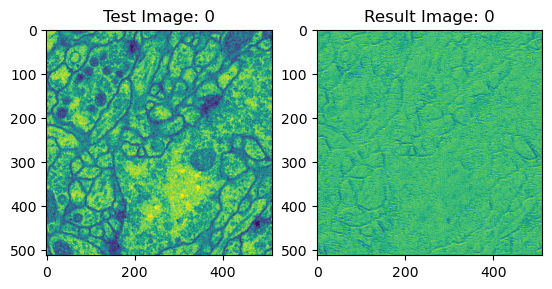

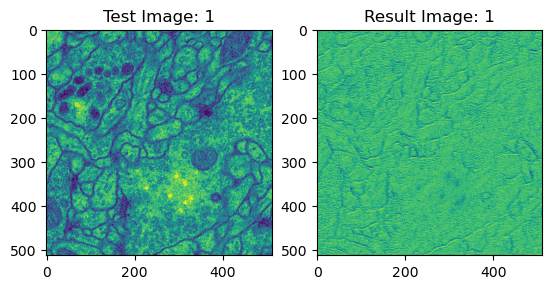

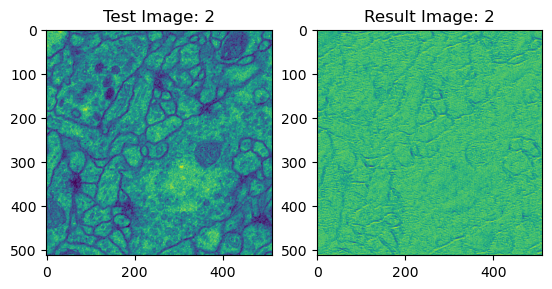

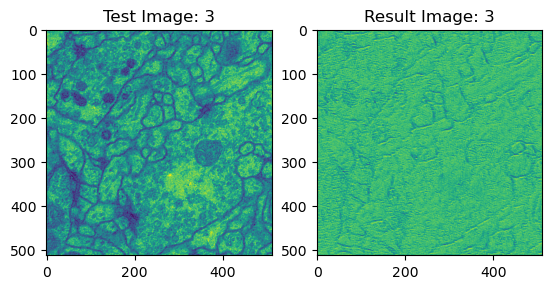

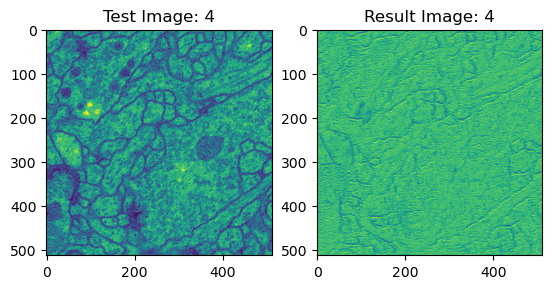

In [29]:
test = []
output = []
for i in range(30):
    image = image_loader('./Data/test/' + str(i) + '.png')
    test.append(image)

with torch.no_grad():
    for i in range(len(test)):
        output.append(model.forward(test[i]))
    
        if i % 10 == 0:
            print(loss.item())
        
for i in range(5):
    test_image_example = plt.subplot(1,2,1)
    test_image_example.set_title('Test Image: ' + str(i))
    imshow(test[i])
    
    result_image_example = plt.subplot(1,2,2)
    result_image_example.set_title('Result Image: ' + str(i))
    imshow(output[i])
    
    plt.show()

현재 U-Net의 **Loss Function을 논문에서 제시한 Weight Cross Entropy가 아닌 MSE로 구현하였기 때문에 Loss는 적어도 만족하지 못한 결과를 얻었다.**
OpenCv를 공부 후 Image처리를 통하여 다시 Loss Function을 구현 후 확인해 봐야하는 사항이다.